In [14]:
import pandas as pd
import matplotlib.pyplot as plt

In [122]:
dados = pd.read_csv('/content/pacientes.csv')

In [123]:
dados.head()

,hemoglobina,leucocitos,plaquetas,glicose,vitamina_d,potassio,calcio,creatinina,ureia,colesterol,Diagnostico
0,17.646079,8833.944020,173353.947328,113.899104,23.066746,4.154862,11.042536,1.045537,39.978448,256.683171,Insuficiência Renal
1,15.600236,9338.710831,164401.491795,98.530836,29.218500,3.631272,8.080539,1.325356,32.600807,217.749149,Hipercalemia
2,16.468107,7366.527764,252306.752948,88.282694,21.355455,3.231540,9.114670,0.585350,39.250656,196.921092,Hipercolesterolemia
3,18.361340,8157.071044,202081.275989,93.774454,25.682238,3.718873,8.862576,0.903077,44.760759,156.338626,Disfunção Renal
4,17.801337,8342.079988,245959.419353,71.837165,11.308341,3.200244,10.365527,1.098512,11.207477,182.501728,Diabetes


In [124]:
X = dados.iloc[:, :-1].values
y = dados.iloc[:, -1].values

In [125]:
from sklearn.cluster import KMeans

X = dados.iloc[:, :-1].values
max_clusters = 10

sse = []

for n_clusters in range(1, max_clusters):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

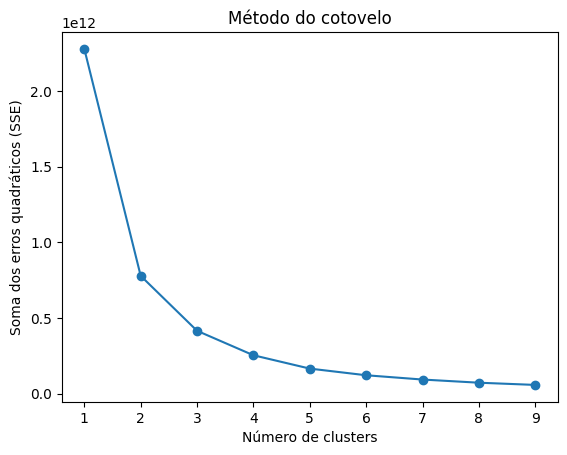

In [126]:
plt.plot(range(1, max_clusters), sse, marker='o')
plt.title('Método do cotovelo')
plt.xlabel('Número de clusters')
plt.ylabel('Soma dos erros quadráticos (SSE)')
plt.show()

## Criando o nosso algoritmo PCA

In [127]:
from sklearn.decomposition import PCA

In [128]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [129]:
explicacao = sum(pca.explained_variance_ratio_)
print(f"Variância explicada pelos 2 componentes selecionados:{explicacao}")

Variância explicada pelos 2 componentes selecionados:0.9999991269529983


In [130]:
colunas = dados.columns[:-1]
pesos = pd.DataFrame(pca.components_, columns=colunas).iloc[0]
pesos = pesos.abs().sort_values(ascending=False)
top_5 = pesos[:5]
print("Top 5 colunas mais importantes:")
for coluna, importancia in zip(top_5.index, top_5.values):
    print(f"{coluna}: {importancia}")

Top 5 colunas mais importantes:
plaquetas: 0.9999999997783077
leucocitos: 1.966624872573597e-05
ureia: 5.3609681947025685e-06
glicose: 3.4616665865824266e-06
vitamina_d: 3.3085019631266935e-06


## Dados desbalanceados

In [131]:
contagem_doencas = dados['Diagnostico'].value_counts().reset_index()
contagem_doencas.columns = ['Diagnostico', 'Contagem']

In [132]:
contagem_doencas = dados['Diagnostico'].value_counts().reset_index()
contagem_doencas.columns = ['Diagnostico', 'Contagem']

In [133]:
contagem_doencas

,Diagnostico,Contagem
0,Hipercolesterolemia,325
1,Disfunção Renal,184
2,Insuficiência Renal,183
3,Diabetes,87
4,Deficiência de Vitamina D,86
5,Hipercalemia,81
6,Infecção,26
7,Anemia,18
8,Trombocitopenia,10


## Gerando dados de minorias com SMOTE

In [136]:
from sklearn.preprocessing import OneHotEncoder

X = dados.drop("Diagnostico", axis=1).values
y = dados["Diagnostico"].values

encoder = OneHotEncoder(sparse=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [140]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

y_resampled_decoded = encoder.inverse_transform(y_resampled)

exames_resampled = pd.DataFrame(X_resampled, columns=dados.columns[:-1])

In [151]:
exames_resampled["Diagnostico"] = y_resampled_decoded

In [152]:
contagem_doencas_m = exames_resampled["Diagnostico"].value_counts().reset_index()
contagem_doencas.columns = ["Diagnostico", "Contagem"]

In [154]:
contagem_doencas_m

,Diagnostico,count
0,Insuficiência Renal,325
1,Hipercalemia,325
2,Hipercolesterolemia,325
3,Disfunção Renal,325
4,Diabetes,325
5,Deficiência de Vitamina D,325
6,Infecção,325
7,Anemia,325
8,Trombocitopenia,325


## Reduzindo os dados da maioria

In [156]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y_encoded)

y_resampled_decoded = encoder.inverse_transform(y_resampled)

In [157]:
y_resampled_decoded = encoder.inverse_transform(y_resampled)

exames_resampled = pd.DataFrame(X_resampled, columns=dados.columns[:-1])

In [161]:
y_resampled_decoded = encoder.inverse_transform(y_resampled)

# Garantindo que y_resampled_decoded é 1D
if y_resampled_decoded.ndim > 1:
    y_resampled_decoded = y_resampled_decoded.ravel()

In [162]:
exames_resampled = pd.DataFrame(X_resampled, columns=dados.columns[:-1])
exames_resampled["Diagnostico"] = y_resampled_decoded

In [164]:
contagem_doencas_d = exames_resampled["Diagnostico"].value_counts().reset_index()
contagem_doencas.columns = ["Diagnostico", "Contagem"]
contagem_doencas_d.head()

,Diagnostico,count
0,Anemia,10
1,Deficiência de Vitamina D,10
2,Diabetes,10
3,Disfunção Renal,10
4,Hipercalemia,10
